We will use a notebook created by Robert Stein (https://github.com/robertdstein) that provides an example of how to classify different ZTF observations in order to find a transient that could be associated with neutrinos observed with IceCube. This procedure will be very similar with Rubin. I have added notes throughout on what we can expect with Rubin.

# Required python packages (pip install)

matplotlib, numpy, os, pickle



In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Loading up the data

When doing neutrino follow-up, we observe a localisation provided by the IceCube neutrino observatory. In this example, we are going to search for possible optical counterparts to IC191001A (https://gcn.gsfc.nasa.gov/gcn/gcn3/25913.gcn3).

In this notebook, so you can get a taste of what neutrino follow-up up is like. The IceCube collaboration provided a spatial localisation of ~30 sq. deg. to search in. We observed this region with Target-Of-Opppoortinuty observations promptly (seven hours after the neutrino detection). 

I have provided absoluely all ZTF alerts data that:

* Was taken in the 24 hours after neutrino detection
* Lies within the 90% localisation contour provided by IceCube.

The data is 130 Mb, without any image cutouts. I applied these two cuts just to make the data volume managaeable for sharing. The data here were provided by Ampel (https://arxiv.org/abs/1904.05922), a ZTF/**LSST** broker. You can find more on LSST brokers at https://rubinobservatory.org/for-scientists/data-products/alerts-and-brokers

**You need to download the datafile from https://www.dropbox.com/s/lexgwbunrh6yefm/ztf_summer_school_neutrinos.pkl?dl=1 and put it this directory to use this notebook.**

In [ ]:
save_path = "day4_ztf_summer_school_neutrinos.pkl"

In [ ]:
if not os.path.isfile(save_path):
    print(f"ERROR: No file found at {save_path}. Make sure to download the data first!")

In [ ]:
with open(save_path, "rb") as f:
    ztf_data = pickle.load(f)

# The format of the data
The ZTF data here is a dictionary, where each key is the name of a ZTF source:

In [ ]:
print(f"This ZTF data contains {len(ztf_data)} different sources. \n\n Their names are: {ztf_data.keys()}")

# Visualising the data
Let's try and visualise these 1390 different objects

In [ ]:
plt.figure()
for source in ztf_data.values():
    plt.scatter(source["candidate"]["ra"], source["candidate"]["dec"], s=0.8)
plt.xlabel("R.A [deg]")
plt.ylabel("Declination [deg]")

They form a nice rectangle. That's not surprising, because the original IceCube contour was a rectangle.

# Analysing a single source
Let's look more closely at one of these sources:

In [ ]:
my_random_source = ztf_data["ZTF19abzkexb"]
print(my_random_source.keys())

There's a lot of information in this random source. ZTF alerts consist of one detection, and then a history of previous detections (and non-detctions) saved under "prv_candidates". The ZTF data stream provides 30 days of history, but here Ampel has aggregated the full history of the source including older detections. 

What information is available for a source?

In [ ]:
ztf_data["ZTF19abzkexb"]["candidate"]

We have a lot of high-level information, for example:
    
- The "drb" (Deep Real/Bogus) score tells us how likely a source is to be real rather than an image artifact. 
- The "ra"/"dec" values tell us where a candidate is on the sky
    
Let's set up some code to plot ZTF lightcurves, and then dig into the history of this source. A key quirk here is that if an entry in prv_candidates has "magpsf" in it, then that's a detection, but if it does not have "magpsf", it is a non-detection/upper limit. 

Another key quirk is that the alert has the "candidate", i.e the detection that generated the alert, and then the previous candidates associated with that name ("prv_candidates"). You need to add the most recent candidate to the previous candidates, in order to have all detections.

Noting these two points, let's get plotting:

In [ ]:
# ZTF color and naming scheme
BAND_NAMES = {1: "ZTF g", 2: "ZTF r", 3: "ZTF i"}
BAND_COLORS = {1: "green", 2: "red", 3: "orange"}

# Neutrino time
neutrino_jd = 2458758.339793634

def plot_lightcurve(ztf_alert):

    plt.figure()
    ax = plt.subplot(111)
    
    # Remember to add in the present detection to the previous detections!
    
    all_detections = ztf_alert["prv_candidates"] + [ztf_alert["candidate"]]
    
    for detection in all_detections:
        
        # Set the colour of the datapoint to match the filter
        # green = g-band, red = r-band, orange = i-band
        c = BAND_COLORS[detection["fid"]]
        
        # Plot detections as scatter points
        if "magpsf" in detection.keys():
            
            plt.scatter(detection["jd"], detection["magpsf"], c=c)
            plt.errorbar(detection["jd"], detection["magpsf"], yerr=detection["sigmapsf"], c=c)
            
        # Plot non-detections as semi-transparent triangles
        else:
            plt.scatter(detection["jd"], detection["diffmaglim"], c=c, marker="v", s=1.3, alpha=0.5,)
    
    # Let's plot the neutrino arrival time as a blue dotted line
    plt.axvline(neutrino_jd, color="blue", linestyle=":", label="IC191001A")
    
    # Invert y axis for "astronomer convention"
    ax.invert_yaxis()
    
    # Set up axis labels
    plt.ylabel("Apparent Magnitude [AB]")
    plt.xlabel("Time [JD]")
    
    # Show a legend()
    plt.legend()
    
    plt.title(ztf_alert["objectId"])

In [ ]:
plot_lightcurve(ztf_data["ZTF19abzkexb"])

This source has clearly been detected several times at the same the neutrino.
It was detected in all three filters (g, r and i). Lightcurves plotted this way are great to visualise the time evolution of the object here. What can we learn about this object?

This is likely a "transient". It does not have a long history of being detected, so is unlikely to be a "variable" object. The "colour" of the object is also interesting. In ZTF, since we mostly use the g/r filters, let's look only at that. Initially the transient appears to be "blue" (it has more light in the green filter than the red filter). However, as time goes on, it becomes more "red" (it has more light in the red filter than the green filter). Many astronomical transients have emission that can be described as a blackbody. Hotter blackbodies appear "blue", cooler ones appear "red". So the lightcurve is telling us that the source starts off hot but then cools down over a period of ~20 days. That's a lot of information for us go on. 

We should already guess that this object might well be a "supernova", since they are known to have lightcurves that rise and fade over dozens of days, and to cool post-peak. We can't be sure without taking additional data (an optical spectrum) though. 

Identifying such objects with ZTF data is the main point of the ZTF neutrino program. We have enough resources to get spectra for a few objects (maybe two, three or four), but certainly not all the ~1400 sources. So we need to identify all the interestng transients in the ZTF data, amongst these 1400 sources, and assign follow-up resources to them. That's main aim of this notebook!

# Finding the needles in the haystack
How can we narrow down the large number of sources?

In general, our data will contain the following categories of object:
    
- Image artifacts
- Solar system objects
- Stars
- Active Galactic Nuclei
- Transients
    
Your goal is to separate the sources into these five categories. There's no one right answer, but let me give you some tips for how I would do it. You can check the solution notebook for a more complete illustration.

### Image Artifacts
Image artifacts can be best-identified by a well-trained human eye, looking at both raw images and image subtractions. Even an untrained human eye is pretty good at this, you're just looking for something Gaussian-like. However, it would be INSANE for a human to look through 1400 different images and identify image artifacts. Instead, ZTF provides a human-eye-approximation, in the form of a neural network (a machine-learning algorithm) thatassigns a score for detections based on whether they look "real" or "bogus". 1=definitely real, 0=definitely bogus. 

**I suggest that you look at a histogram of "drb" scores from the sources, and make a cut somewhere reasonable between 0 and 1. Everything below that score is probably an image artifact.**

### Solar System Objects
Solar system objects (asteroids, comets, minor planets, satellites) are objects in our solar system. They are charateised by their distinctive feature: unlike distant stars and galaxies, SSOs will move noticeably over the duration of a night. ZTF detections are based on position on the sky. 

**Requiring that an object was detected at least twice in total, in the same position, with a separation of 15 minutes is an excellent way to filter our SSOs.**

*Reminder: you should only count detections (entries in "prv_candidates" with "magpsf"), but NOT count non-detections. Also, don't forget to include the most recent detection ("candidate") and add it to the historical detections ("prv_candidates").*


### Stars
Stars can often be identified via the morphology. The PanSTARRS survey is a deeper survey than ZTF, with a catalogue of a billion sources. Machine learning has been used to assign a "Star/Galaxy" score to each of these (1=Star, 0=galaxy, see https://arxiv.org/abs/1902.01935 for more info). ZTF data is cross-matched to these, and the closest three panstarrs sources are included in the alert. The alert includes the magnitudes in g and r (sgmag1/sgmag2/sgmag3), and the star/galaxy score (sgscore1/2/3), for the three nearest sources. The distance to each is provided too (distpsnr1/2/3, in units or arseconds). 

**I would suggest that you make a list of sgscores. Loop over each ZTF source, and add the sgscore of the nearest panstarrs source to your list (that's 'sgscore1'). Make a histogram of these values, and decide where you want to make a cut. Remember, a high sgscore means a source is probably a star! Unlike step 1, where you wanted high drb scores, here we want LOW sgscores.**

**Once you have decided on an sgscore cut, then you should use that to select likely stars. You should loop over each ZTF source, and check the distance to the nearest panstarrs source. If that distance is <3 arcseconds, and the sgscore is less than your threshold, you the source is probably a star.**

### AGN
Active Galactic Nucleii (AGN) are objects that vary in time. Unlike transients, which typically rise and then fall, AGN will often be detected many times over a long period of time. They might not vary very much.

By this point, you should not have many candidates left (e.g I had ~50 sources left). At this point you should start doing human inspection. The easiest way to distinguish AGN/non-AGN is by eye. 

My rule of thumb:

-If there is some indication of a steady rise and/or fall, it is a 'Probable Transient'. 

-If it detected a couple of times within a short timespan of a couple of days, it is a 'Possible Transient'.

-If it is detected in at two different time clusters without evolving much, then you cannot rule out some rise and fall that went in the gap. However, it is unlikely. I would categorise this as 'Probable AGN'. 

-If something is detected many times without a single rapid rise+fall, then it is a 'Definite AGN'. It can either evolve super slowly over thousands of days, or vary both up and down.

As you might realise, my "rule of thumb" is biased. We err on the side of not classifying something as an AGN unless we are pretty certain. If something is possibly a transient, we should investigate it further.

Below is an example of each category:

In [ ]:
# Probable transient (our trusty supernova from earlier)
plot_lightcurve(ztf_data["ZTF19abzkexb"])

In [ ]:
# Possible Transient
plot_lightcurve(ztf_data["ZTF19acbwosz"])

In [ ]:
# Probable AGN
plot_lightcurve(ztf_data["ZTF19abeyhsj"])

In [ ]:
# Definite AGN (slow evolving)
plot_lightcurve(ztf_data["ZTF19abjflnc"])

In [ ]:
# Definite AGN (variable)
plot_lightcurve(ztf_data["ZTF18abzqgou"])

If you want to move beyond "scanning" manually for candidates, you can also look for arcchival detections in https://ned.ipac.caltech.edu/. AGN will often be in catalogues, such as https://heasarc.gsfc.nasa.gov/W3Browse/all/milliquas.html. If somethingf is in Milliquas, it's probaby an AGN. If not, it might still be an AGN.

However, I think the lightcurves can already give you a strong hint. I would suggest you discuss difficult cases with your fellow students. This is what we do in the real world, too! A second (third, or fifth) opinion is always helpful.

***Create a python dictionary, with an entry for your remaining objects. Assign each a classification to each of your remaining sources, with categories of probable transient, possible transient, probable AGN, or definite AGN.***

Example, using the lightcurves above:

In [ ]:
my_classifications = {
    "ZTF19abzkexb": "Probable Transient",
    "ZTF19acbwosz": "Possible Transient",
    "ZTF19abeyhsj": "Probable AGN",
    "ZTF19abjflnc": "Definite AGN",
    "ZTF18abzqgou": "Definite AGN"
}

## How to code this up?

My suggestion is to go down this list, and split the data into the five categories:

- Design a function to divide the alerts into image artifacts or real objects. Apply it to the full data, and see what fraction come of ZTF sources are from image artifacts. 
- Design a function to divide alerts into SSO or non-SSO. Apply it to the real objects from the previous step, and see what fraction of real objects are SSOs.
- Design a function to divide alerts into star or non-star. Apply it to the non-SSO objects from the previous step, and see what fraction of non-SSOs are stars.

Now we are hopefully only left with AGN and transients. It is posssible to differentiate transients from AGN by eye as we did above, but we can specifically look for TDEs using what you learned in the lectures this morning. Some characteristics you can use are:
- Rise time to peak (how many days to go from 1 mag below peak to peak)
- Decline time from peak (how many days to decline by 1 mag)
- Average g-r color
- g-r color evolution (mag / day)

In [110]:
alerts = pd.DataFrame([{"objectId": key} | ztf_data[key]['candidate'] for key in ztf_data.keys()])

alerts = alerts[
    (alerts['drb'] > 0.7) & 
    ((alerts['ssdistnr'] < 0) | (alerts['ssdistnr'] > 5)) &
    (alerts['distpsnr1'] < 2) &
    (alerts['sgscore1'] <= 0.5) &
    (alerts['ndethist'] < 400)
]

print(len(alerts), "remaining")

cand_objids = alerts['objectId'].values

# for objid in cand_objids:
#     plot_lightcurve(ztf_data[objid])

43 remaining


Now we are hopefully only left with AGN and transients. It is posssible to differentiate transients from AGN by eye as we did above, but we can specifically look for TDEs using what you learned in the lectures this morning. Some characteristics you can use are:
- Rise time to peak (how many days to go from 1 mag below peak to peak)
- Decline time from peak (how many days to decline by 1 mag)
- Average g-r color
- g-r color evolution (mag / day)

Here is a method that reorganizes the data into a dictionary with 2-D arrays of the different band magnitudes that might be helpful with this last step in the analysis:

In [96]:
def reorg_data(ztf_alert):
    all_detections = ztf_alert["prv_candidates"] + [ztf_alert["candidate"]]
    gtimes=[]
    rtimes=[]
    itimes=[]
    gmag=[]
    rmag=[]
    imag=[]

    detection_lists = {"ZTF g": [],
                       "ZTF r": [],
                       "ZTF i": []
                      }

    for detection in all_detections:
        if "magpsf" in detection.keys():
            c = BAND_NAMES[detection["fid"]]
            detection_lists[c].append(np.array([detection['jd'],detection['magpsf']]))


    empty=[]
    for i in detection_lists.keys():
        if len(detection_lists[i])==0:
            empty.append(i)

    for i in empty:
        detection_lists.pop(i)

    
    min_time=1e10
    for i in detection_lists.keys():
            detection_lists[i]=np.array(detection_lists[i])
            detection_lists[i]=detection_lists[i].T

            detection_lists[i][1]=detection_lists[i][1][np.argsort(detection_lists[i][0])]
            detection_lists[i][0]=detection_lists[i][0][np.argsort(detection_lists[i][0])]

            
            min_test=min(detection_lists[i][0])
            if min_test<min_time:
                min_time=min_test

        
    for i in detection_lists.keys():
        detection_lists[i][0]-=min_time
    
    
    return detection_lists

At the end you should have five groups:
- image artifacts
- SSOs
- stars
- AGN (definite and probable) + non-TDE transients
- TDEs

Make a pie chart illustrating the relative size of the different categories!

In [111]:
short_lcs = []

for objid in cand_objids:
    lc = reorg_data(ztf_data[objid])
    
    g_length = len(lc.get('ZTF g', [[]])[0])
    r_length = len(lc.get('ZTF r', [[]])[0])
    i_length = len(lc.get('ZTF i', [[]])[0])
    
    lc_length = np.sum([g_length, r_length, i_length])
    
    if (lc_length < 10) | (g_length < 1) | (r_length < 1):
        short_lcs.append(objid)

print(len(short_lcs), "to remove")

alerts = alerts[~alerts['objectId'].isin(short_lcs)]
print(len(alerts), "remaining")

27 to remove
16 remaining


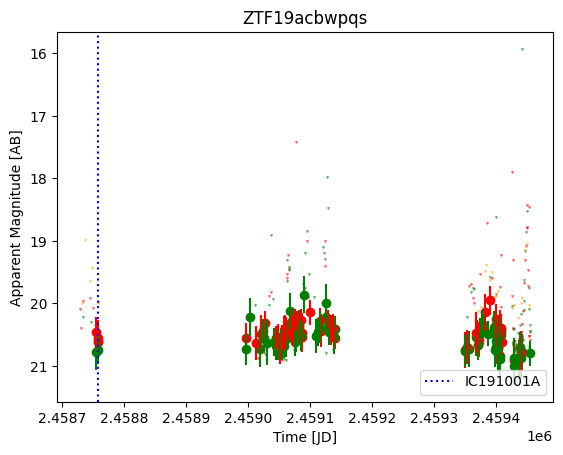

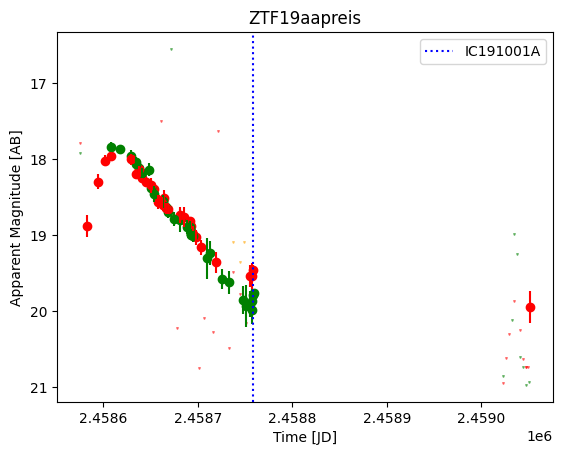

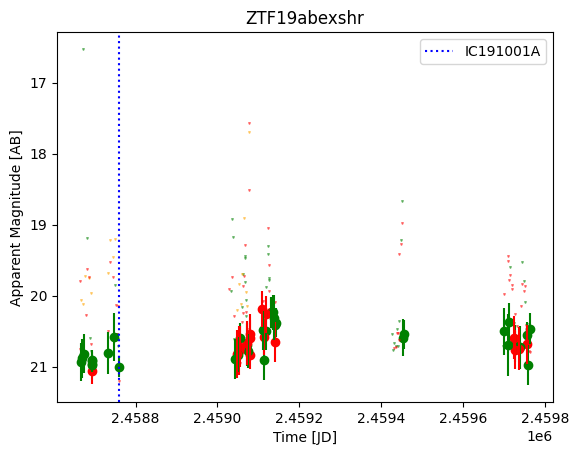

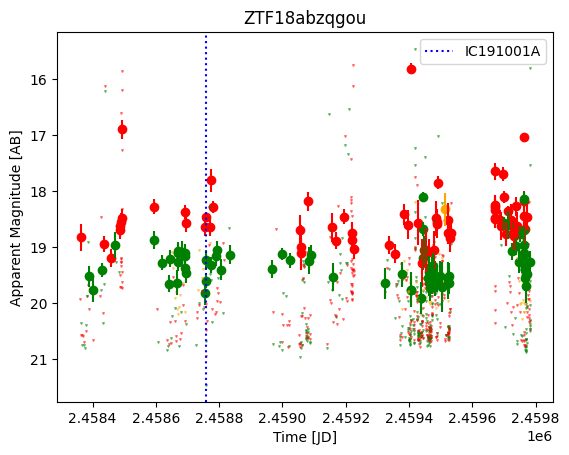

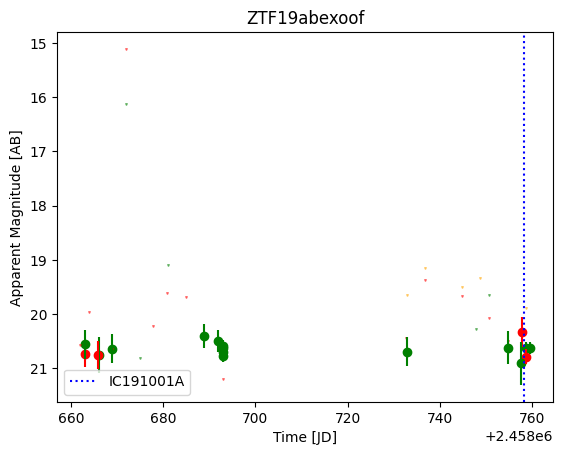

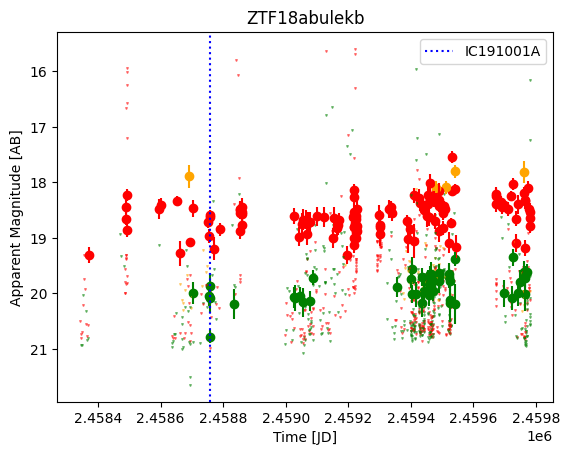

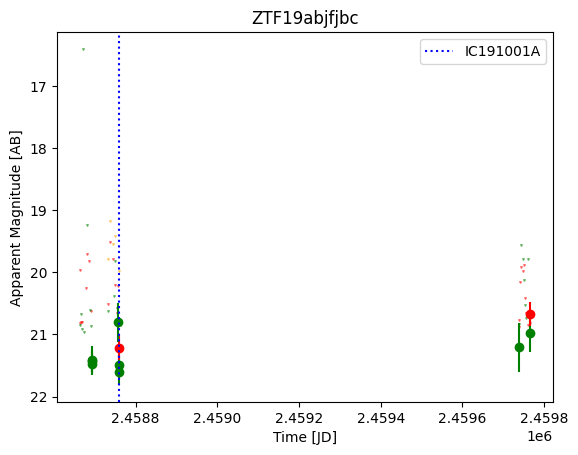

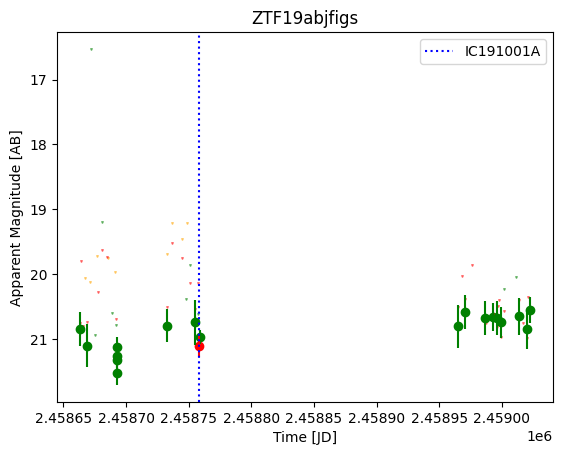

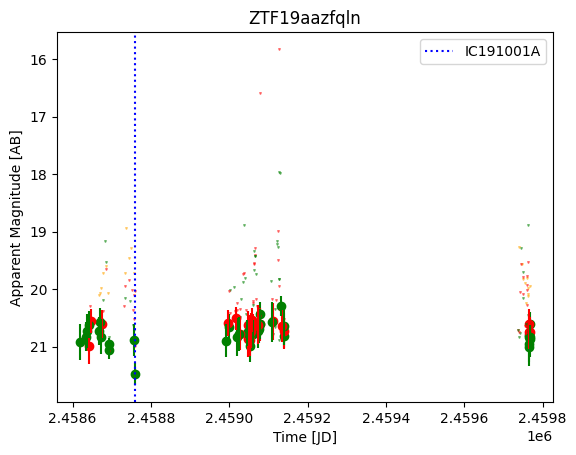

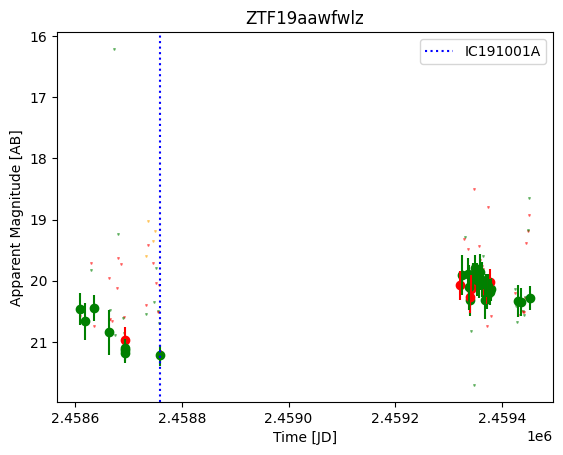

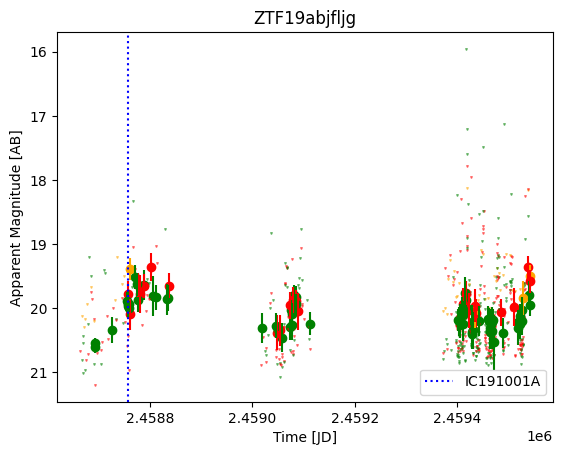

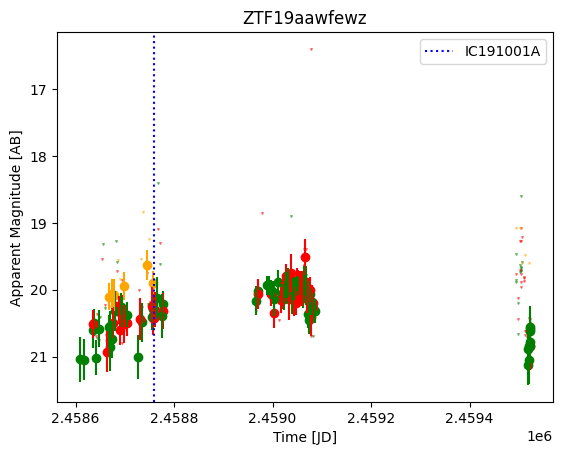

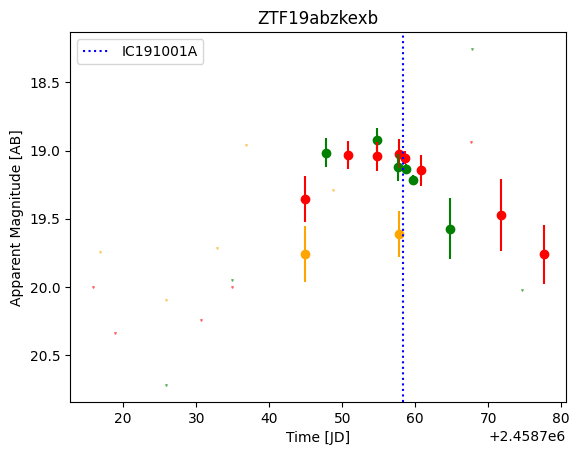

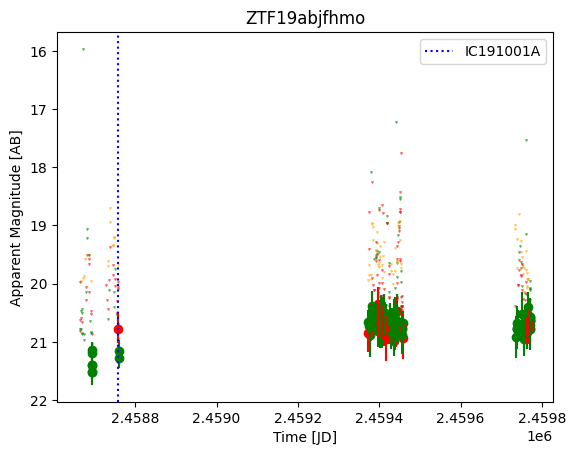

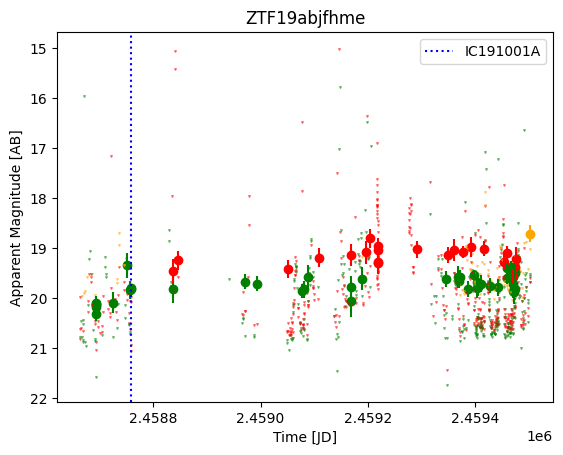

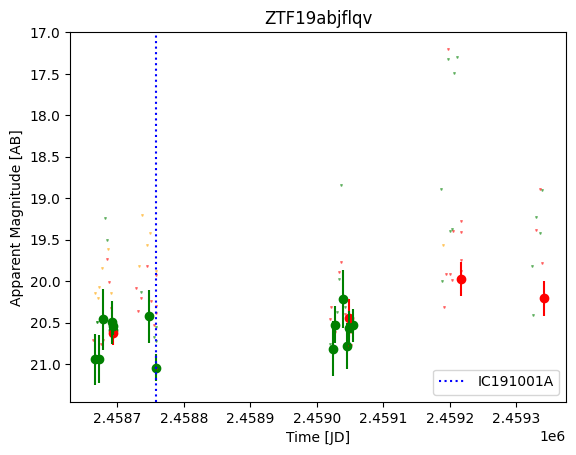

In [112]:
cand_objids = alerts['objectId'].values

for objid in cand_objids:
    plot_lightcurve(ztf_data[objid])

In [144]:
def get_rise_time(lc):
    idx_10p = np.argmin(np.abs(lc[1] - np.percentile(lc[1], 5)))

    mag_10p = lc[1][idx_10p]
    mag_first = lc[1][0]

    t_10p = lc[0][idx_10p]
    t_first = lc[0, 0]
    
    return (mag_10p - mag_first) / (t_10p - t_first)

In [148]:

for objid in cand_objids:
    lc = reorg_data(ztf_data[objid])
    
    g_lc = lc.get('ZTF g')
    r_lc = lc.get('ZTF r')
    
    g_rise = get_rise_time(g_lc)
    r_rise = get_rise_time(r_lc)
    
    g_mag_10p = g_lc[1][np.argmin(np.abs(g_lc[1] - np.percentile(g_lc[1], 5)))]
    r_mag_10p = r_lc[1][np.argmin(np.abs(r_lc[1] - np.percentile(r_lc[1], 5)))]
    
    g_mag_first = g_lc[1][0]
    r_mag_first = r_lc[1][0]
    
    alerts.loc[alerts['objectId'] == objid, 'g_rise_time'] = g_rise
    alerts.loc[alerts['objectId'] == objid, 'r_rise_time'] = r_rise
    
    print(f"Rise time for {objid} in g-band: {g_rise:.3f} {g_mag_10p:.3f} {g_mag_first:.3f}")
    print(f"Rise time for {objid} in r-band: {r_rise:.3f} {r_mag_10p:.3f} {r_mag_first:.3f}\n")


Rise time for ZTF19acbwpqs in g-band: -0.002 20.219 20.784
Rise time for ZTF19acbwpqs in r-band: -0.000 20.251 20.463

Rise time for ZTF19aapreis in g-band: 0.005 17.957 17.847
Rise time for ZTF19aapreis in r-band: -0.019 18.007 18.879

Rise time for ZTF19abexshr in g-band: -0.001 20.310 20.931
Rise time for ZTF19abexshr in r-band: -0.002 20.227 21.065

Rise time for ZTF18abzqgou in g-band: -0.001 18.682 19.525
Rise time for ZTF18abzqgou in r-band: -0.001 17.650 18.828

Rise time for ZTF19abexoof in g-band: -0.002 20.494 20.559
Rise time for ZTF19abexoof in r-band: -0.004 20.336 20.731

Rise time for ZTF18abulekb in g-band: -0.001 19.568 19.992
Rise time for ZTF18abulekb in r-band: -0.001 18.162 19.307

Rise time for ZTF19abjfjbc in g-band: -0.009 20.802 21.417
Rise time for ZTF19abjfjbc in r-band: -0.001 20.669 21.217

Rise time for ZTF19abjfigs in g-band: -0.001 20.581 20.844
Rise time for ZTF19abjfigs in r-band: nan 21.108 21.108

Rise time for ZTF19aazfqln in g-band: -0.001 20.564 

/var/folders/jn/p0g0f05x64b5yxz9ppdkcswh0000gn/T/ipykernel_9398/2904676596.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return (mag_10p - mag_first) / (t_10p - t_first)


In [155]:
alerts.sort_values(by='r_rise_time', inplace=True)

alerts

,objectId,jd,fid,pid,diffmaglim,programid,candid,isdiffpos,tblid,nid,...,clrrms,neargaia,neargaiabright,maggaia,maggaiabright,exptime,drb,drbversion,g_rise_time,r_rise_time
889,ZTF19abzkexb,2.458778e+06,2,1023094542115,20.098610,1,1023094542115015002,t,2,1023,...,0.228965,39.469677,-999.000000,19.966282,-999.000000,30.0,0.999288,d6_m7,-0.013163,-0.025735
157,ZTF19aapreis,2.459052e+06,2,1297365775515,20.666857,1,1297365775515015007,t,7,1297,...,0.166850,0.664165,60.322681,18.368277,12.654293,30.0,0.998881,d6_m7,0.005259,-0.018973
256,ZTF19abexoof,2.458760e+06,1,1005190302115,21.513510,2,1005190302115015052,t,52,1005,...,0.158799,0.304083,53.319778,19.501059,13.293869,300.0,0.995720,d6_m7,-0.002249,-0.004170
196,ZTF19abexshr,2.459765e+06,1,2010399625915,20.774799,1,2010399625915015024,t,24,2010,...,0.159251,9.114525,52.202156,19.515793,13.452401,30.0,0.999656,d6_m7,-0.001315,-0.001915
861,ZTF19aawfewz,2.459524e+06,1,1769205125615,20.671326,2,1769205125615015018,t,18,1769,...,0.197944,0.189991,-999.000000,19.450077,-999.000000,30.0,0.998810,d6_m7,-0.002650,-0.001817
821,ZTF19aawfwlz,2.459454e+06,1,1699212665015,20.705973,1,1699212665015015000,t,0,1699,...,0.168897,0.210826,-999.000000,19.113554,-999.000000,30.0,0.999509,d6_m7,-0.000803,-0.001601
1137,ZTF19abjfhme,2.459503e+06,3,1748286515115,18.991436,2,1748286515115015006,t,6,1748,...,0.093428,0.449375,69.403740,16.757101,11.676620,30.0,0.998614,d6_m7,-0.000969,-0.001328
1388,ZTF19abjflqv,2.459341e+06,2,1586422753615,20.176453,1,1586422753615015006,t,6,1586,...,0.215591,10.292918,-999.000000,17.858696,-999.000000,30.0,0.998566,d6_m7,-0.006385,-0.001252
807,ZTF19aazfqln,2.459769e+06,1,2014379905815,20.903894,2,2014379905815010011,f,11,2014,...,0.198465,0.213918,-999.000000,19.576939,-999.000000,30.0,0.995940,d6_m7,-0.000726,-0.001087
441,ZTF18abulekb,2.459783e+06,2,2028358663915,20.475010,2,2028358663915010011,f,11,2028,...,0.244664,0.101149,68.281937,15.944529,12.916406,30.0,0.733467,d6_m7,-0.000607,-0.001021


### Ranking Potential Transients

Now you've finished the categorisation, think about the following question:

**If I said you could take a spectrum (and therefore classify) three sources, which of your sources would you choose?**

You might have a few dozen sources left, where you cannot tell if they are AGN or transients. How would you prioritse, if you cannot classify all? Looking at the lightcurves is essential here. In general you should try to find the objects which you suspect are most likely to be transients (the 'probable transient' category). Those that are bright, or have a clear/coherent lightcurve with more than a 2-3 detections, are the most promising. See whether they match the ones we chose in the solutions notebook!

### Bonus: Analyzing your Light Curve

Choose your most likely TDE candidate and fit a power-law to the section with decreasing magnitude. How close is this power-law to $t^{-5/3}$?

Can you use what you learned in this morning's lectures to estimate system parameters based on the TDE rise time? 


In [166]:
lc = reorg_data(ztf_data["ZTF19aapreis"])

lc

{'ZTF g': array([[ 25.004757  ,  34.9978935 ,  45.9957176 ,  51.9963773 ,
          52.0136343 ,  54.9968403 ,  57.9809259 ,  64.9997454 ,
          67.994838  ,  70.9308449 ,  79.9594907 ,  79.9867361 ,
          82.9958565 ,  85.9783333 ,  91.9631019 ,  97.9805208 ,
         105.8560995 , 108.8652431 , 109.9434954 , 109.9470718 ,
         109.9506482 , 109.9963657 , 111.8652778 , 126.9770023 ,
         129.7395486 , 142.8529398 , 149.838831  , 164.8128472 ,
         167.7438079 , 171.7910417 , 174.7091204 , 174.725625  ,
         175.7237037 , 176.7253935 ],
        [ 17.84659576,  17.87247276,  17.95698929,  18.0718441 ,
          18.04423714,  18.12383461,  18.18528366,  18.14103699,
          18.38185883,  18.46289253,  18.54864502,  18.56327248,
          18.63059425,  18.69514275,  18.79042816,  18.80914688,
          18.89609146,  18.8998661 ,  19.00520897,  18.99244499,
          18.98657417,  18.9459362 ,  19.0178318 ,  19.31019974,
          19.23727417,  19.58001137,  19.62

In [182]:
g_mag = lc['ZTF g'][1][2:-8]
g_t = lc['ZTF g'][0][2:-8]

g_flux = 10**((g_mag + 48.60) / -2.5)
g_flux /= np.max(g_flux)

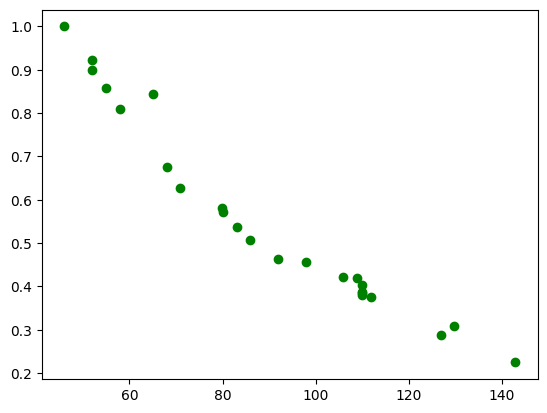

In [183]:
# plt.scatter(g_lc[0], g_lc[1], c='green', s=0.5)
plt.scatter(g_t, g_flux, c='g')
# plt.gca().invert_yaxis()

Fitted exponent: -1.190
Theoretical t^(-5/3) exponent: -1.667
Difference from theoretical: 0.477


/var/folders/jn/p0g0f05x64b5yxz9ppdkcswh0000gn/T/ipykernel_9398/898805300.py:6: RuntimeWarning: overflow encountered in power
  return a * (x + b)**c + d
/var/folders/jn/p0g0f05x64b5yxz9ppdkcswh0000gn/T/ipykernel_9398/898805300.py:6: RuntimeWarning: invalid value encountered in power
  return a * (x + b)**c + d


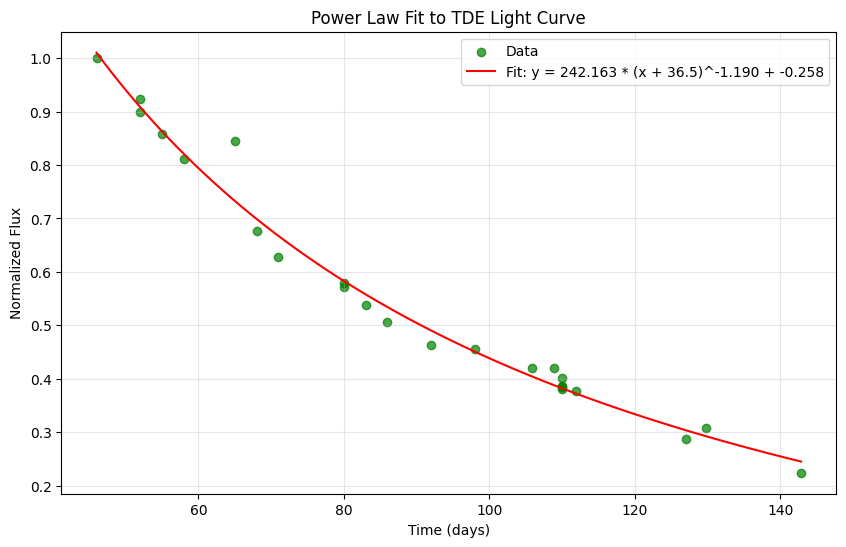

In [185]:
from scipy.optimize import curve_fit

# Define power law function with optional shifts
def power_law(x, a, b, c, d):
    """Power law function: y = a * (x + b)^c + d"""
    return a * (x + b)**c + d

# Initial guess for parameters [amplitude, x_shift, exponent, y_shift]
initial_guess = [1.0, 0.0, -5/3, 0.0]

# Fit the curve
popt, pcov = curve_fit(power_law, g_t, g_flux, p0=initial_guess, maxfev=10000)

# Generate fitted curve for plotting
t_fit = np.linspace(g_t.min(), g_t.max(), 100)
flux_fit = power_law(t_fit, *popt)

# Plot the data and fit
plt.figure(figsize=(10, 6))
plt.scatter(g_t, g_flux, c='g', label='Data', alpha=0.7)
plt.plot(t_fit, flux_fit, 'r-', label=f'Fit: y = {popt[0]:.3f} * (x + {popt[1]:.1f})^{popt[2]:.3f} + {popt[3]:.3f}')
plt.xlabel('Time (days)')
plt.ylabel('Normalized Flux')
plt.title('Power Law Fit to TDE Light Curve')
plt.legend()
plt.grid(True, alpha=0.3)

print(f"Fitted exponent: {popt[2]:.3f}")
print(f"Theoretical t^(-5/3) exponent: {-5/3:.3f}")
print(f"Difference from theoretical: {abs(popt[2] - (-5/3)):.3f}")